In [1]:
# !pip install pmdarima

In [1]:
## Imports for connection with Azure SQL Database Server
import pyodbc
from sqlalchemy import create_engine

In [2]:
## Importing Libraries and Tools for EDA and predictive Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

## **Data Collection**

In [4]:
## Connection details to establish the connection

server = "qaececrm-s2.database.windows.net"
database = "QAECECRM_S2"
username = "dbadmin"
password = "DashTech1234"

## Connection String to establsifh connection
connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+18+for+SQL+Server'

## Establising the connection using sqlalchemy with creat_engine
engine = create_engine(connection_string)

### **1. Query's for Data Retrieval**

In [5]:
## WE are only Taking Dates after year 2000, we came to this conclusion because of EDA.
Contract_TQ = """
Select c.ContractId, c.AgentId, o.Abbreviation as Office, et.Name as EventType, at.Name as ActType, c.VenueName, c.VenuePhysicalCity, c.ContractDueDate, c.Gross
From [dbo].[Contract] c
JOIN [dbo].[LuOffice] o ON c.OfficeId = o.OfficeId
JOIN [dbo].[LuEventType] et ON c.EventTypeId = et.EventTypeId
JOIN [dbo].[ContractArtist] ca ON c.ContractId = ca.ContractId
JOIN [dbo].[ArtistActType] aat ON aat.ArtistId = ca.ArtistId
JOIN [dbo].[LuActType] at ON aat.ActTypeId = at.ActTypeId
Where Year(c.ContractDueDate) >= 2000 AND Year(c.ContractDueDate) < 2024 
Order By c.ContractDueDate
"""

## Agent Profits by payment logs
AgentPL_TQ = """
Select AgentId, GrossAmount, NetAmount, GrossAmount - NetAmount as Profit, ReceivedDate
From [dbo].[AgentPayrollLog]
Where Year(ReceivedDate) >= 2000 AND Year(ReceivedDate) < 2024 
Order By ReceivedDate
"""

In [6]:
Contract_df = pd.read_sql(Contract_TQ, engine)
Contract_df.head(10)

,ContractId,AgentId,Office,EventType,ActType,VenueName,VenuePhysicalCity,ContractDueDate,Gross
0,151686,313,RIC,Club,Bands,"LIGHTFOOTS, HYATT RICHMOND",RICHMOND,2000-01-01,1900.0
1,152066,397,RIC,Dance,Bands,NATIONAL MUSEUM OF WOMEN IN THE ARTS,WASHINGTON,2000-01-01,500.0
2,152200,196,RIC,Christmas Party,DJs,HOLIDAY INN 1776,RICHMOND,2000-01-01,100.0
3,152201,277,RIC,Christmas Party,Soloist/Duos/Trios,THORNBERG RESIDENCE IN THE COUNTRY CLUB HILL S...,ASHLAND,2000-01-01,350.0
4,152208,313,RIC,Dance,Bands,CATHOLIC CHURCH PAVILLION,SOUTH HILL,2000-01-01,10000.0
5,152209,419,RIC,Dance,Rock,"TAZEWELL ROOM, KINGSMILL RESORT AND CONFERENCE...",WILLIAMSBURG,2000-01-01,4975.0
6,152209,419,RIC,Dance,International,"TAZEWELL ROOM, KINGSMILL RESORT AND CONFERENCE...",WILLIAMSBURG,2000-01-01,4975.0
7,326868,413,ATL,Other,Nationals,THE MUSEUM OF NATURAL HISTORY,NEW YORK,2000-01-01,55000.0
8,326879,134,ATL,Dance,Bands,MAISON AND JARDIN,ORLANDO,2000-01-01,1500.0
9,253880,192,CLT,Club,Bands,RED'S,RALEIGH,2000-01-03,1000.0


In [7]:
Contract_df.tail()

,ContractId,AgentId,Office,EventType,ActType,VenueName,VenuePhysicalCity,ContractDueDate,Gross
215242,841284,155,CLT,Private/Social,Soloist/Duos/Trios,CAROLINA PANTHERS/ South Club Lounge,CHARLOTTE,2023-12-24,1000.0
215243,841285,155,CLT,Private/Social,Soloist/Duos/Trios,CAROLINA PANTHERS/ North Club Lounge,CHARLOTTE,2023-12-24,1000.0
215244,842085,155,CLT,Private/Social,DJs,Atrium Health Dome,Charlotte,2023-12-27,500.0
215245,842044,155,CLT,Private/Social,Bands,CAROLINA PANTHERS/ Champions Village,CHARLOTTE,2023-12-27,1000.0
215246,842044,155,CLT,Private/Social,Soloist/Duos/Trios,CAROLINA PANTHERS/ Champions Village,CHARLOTTE,2023-12-27,1000.0


In [8]:
AgentPL_df = pd.read_sql(AgentPL_TQ, engine)
AgentPL_df.head(10)

,AgentId,GrossAmount,NetAmount,Profit,ReceivedDate
0,419,135.0,54.0,81.0,2000-01-03
1,110,200.0,80.0,120.0,2000-01-04
2,110,200.0,80.0,120.0,2000-01-04
3,122,25.0,7.5,17.5,2000-01-04
4,125,1400.0,490.0,910.0,2000-01-04
5,134,2000.0,600.0,1400.0,2000-01-04
6,163,400.0,140.0,260.0,2000-01-04
7,187,450.0,157.5,292.5,2000-01-04
8,187,250.0,87.5,162.5,2000-01-04
9,188,700.0,280.0,420.0,2000-01-04


### **2. Analyzing the tables**

#### 1. Agent Payroll Table

In [9]:
# Ensure 'ReceivedDate' is in datetime format
AgentPL_df['ReceivedDate'] = pd.to_datetime(AgentPL_df['ReceivedDate'])

# Step 1: Create a Year-Week column using the correct weekly format
AgentPL_df['YearWeek'] = AgentPL_df['ReceivedDate'].dt.to_period('W').apply(lambda r: r.start_time)

# Step 2: Group by 'YearWeek' and sum 'Profit'
profit_grouped_df = AgentPL_df.groupby(['YearWeek'])['Profit'].sum().reset_index()

# Step 3: Fill NaN values with 0 if needed (optional)
profit_grouped_df['Profit'] = profit_grouped_df['Profit'].fillna(0)


In [10]:
# Display the first few rows
profit_grouped_df['YearWeek'] = pd.to_datetime(profit_grouped_df['YearWeek'])
profit_grouped_df.tail(10)


,YearWeek,Profit
1228,2023-07-17,259828.74
1229,2023-07-24,100812.41
1230,2023-07-31,111114.98
1231,2023-08-07,170757.80
1232,2023-08-14,125873.90
1233,2023-08-21,140254.96
1234,2023-08-28,236143.17
1235,2023-09-04,1900.00
1236,2023-10-16,4850.00
1237,2023-10-23,2850.00


In [11]:
profit_grouped_df = profit_grouped_df[:-4]
profit_grouped_df.reset_index(drop=True, inplace=True)
profit_grouped_df.tail(10)

,YearWeek,Profit
1224,2023-06-19,265334.50
1225,2023-06-26,174365.24
1226,2023-07-03,146128.33
1227,2023-07-10,58071.82
1228,2023-07-17,259828.74
1229,2023-07-24,100812.41
1230,2023-07-31,111114.98
1231,2023-08-07,170757.80
1232,2023-08-14,125873.90
1233,2023-08-21,140254.96


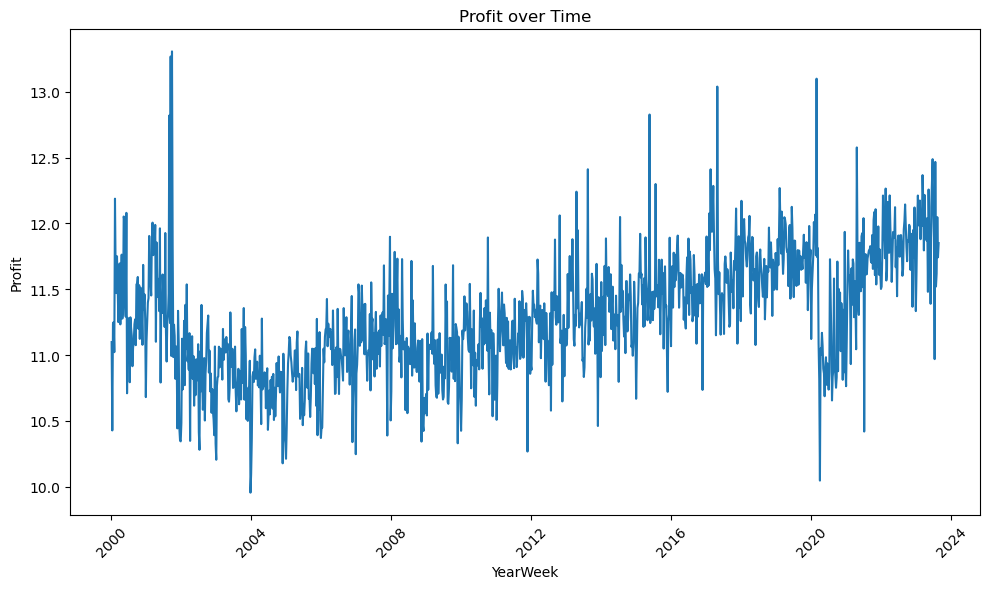

In [12]:

# Assuming profit_grouped_df is your DataFrame

# Convert 'YearWeek' and 'Profit' to NumPy arrays before plotting
yearweek_array = profit_grouped_df['YearWeek'].to_numpy()  # Converting YearWeek to numpy array
profit_array = profit_grouped_df['Profit'].to_numpy()  # Converting Profit to numpy array
profit_array = np.log(profit_array + 1)

# Ensure there are no invalid values
profit_grouped_df = profit_grouped_df.dropna()

# Plotting using the numpy arrays
plt.figure(figsize=(10, 6))
plt.plot(yearweek_array[:, None], profit_array)  # Using numpy arrays for multi-dimensional indexing

# Set the x-axis format for dates and adjust limits
plt.gca().xaxis_date()  # Ensure x-axis is treated as dates
plt.xlabel('YearWeek')
plt.ylabel('Profit')
plt.title('Profit over Time')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

In [13]:
profit_series = profit_grouped_df['Profit']
profit_series = np.log(profit_series + 1)

In [14]:
# Perform Augmented Dickey-Fuller test to check stationarity
adf_result = adfuller(profit_series)

# Print ADF statistics
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Interpretation:
if adf_result[1] > 0.05:
    print("The data is non-stationary. Differencing might be required.")
else:
    print("The data is stationary.")

ADF Statistic: -2.0449845027369817
p-value: 0.2672037002372867
The data is non-stationary. Differencing might be required.


In [15]:
# Apply first-order differencing to log-transformed data
profit_series = profit_series.diff().dropna()  # Drop NA values caused by differencing

In [16]:
# Perform Augmented Dickey-Fuller test to check stationarity
adf_result = adfuller(profit_series)

# Print ADF statistics
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Interpretation:
if adf_result[1] > 0.05:
    print("The data is non-stationary. Differencing might be required.")
else:
    print("The data is stationary.")

ADF Statistic: -12.116467257911088
p-value: 1.8674695365319714e-22
The data is stationary.


In [17]:
# Define the split point (for example, the last 20% of data as test set)
train_size = int(len(profit_series) * 0.8)
train, test = profit_series[:train_size], profit_series[train_size:]

# Print the lengths of the train and test sets
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 986, Test size: 247


In [18]:
# Seasonal Auto-ARIMA model (adjust m for your seasonal period, e.g., m=12 for monthly seasonality)
auto_model_seasonal = auto_arima(train, seasonal=True, m=12, trace=True, suppress_warnings=True)

# Forecast the next 10 periods (or as many as you need)
forecast_seasonal = auto_model_seasonal.predict(n_periods=len(test))

# Calculate the accuracy for seasonal model
mae_seasonal = mean_absolute_error(test, forecast_seasonal)
mse_seasonal = mean_squared_error(test, forecast_seasonal)
rmse_seasonal = np.sqrt(mse_seasonal)
mape_seasonal = np.mean(np.abs((test - forecast_seasonal) / test)) * 100

# Print the seasonal model's accuracy
print(f"MAE (seasonal): {mae_seasonal}")
print(f"MSE (seasonal): {mse_seasonal}")
print(f"RMSE (seasonal): {rmse_seasonal}")
print(f"MAPE (seasonal): {mape_seasonal}%")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=441.873, Time=3.20 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=965.484, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=636.406, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=466.803, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=963.486, Time=0.06 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=441.290, Time=2.48 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=442.113, Time=1.10 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=446.210, Time=4.53 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=440.846, Time=2.06 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=443.253, Time=4.56 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=443.811, Time=5.43 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=463.977, Time=1.71 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=444.374, Time=1.17 sec
 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=444.607, Time=2.60 sec
 ARIMA(2,0,3)(1,0,0)[12] intercep

In [19]:
print(forecast_seasonal)

[-1.22783482e-01  1.35586404e-02  1.62167883e-02 -1.41778994e-02
  3.86418273e-03 -2.11840320e-02  1.89861778e-02  4.71617372e-03
 -1.22981792e-02  1.10106868e-02  2.70158863e-02 -2.72446387e-02
  7.89700998e-03 -1.88302705e-03  1.15089197e-04 -2.02655391e-04
 -9.02606320e-05 -7.56712365e-05 -5.23151252e-05 -3.80216249e-05
 -2.72588301e-05 -1.96146556e-05 -1.41001040e-05 -1.01386612e-05
 -7.28966181e-06 -5.24134404e-06 -3.76856190e-06 -2.70962544e-06
 -1.94824109e-06 -1.40080017e-06 -1.00718595e-06 -7.24174341e-07
 -5.20686847e-07 -3.74377795e-07 -2.69180477e-07 -1.93542806e-07
 -1.39158746e-07 -1.00056195e-07 -7.19411636e-08 -5.17262427e-08
 -3.71915611e-08 -2.67410147e-08 -1.92269925e-08 -1.38243536e-08
 -9.93981515e-09 -7.14680254e-09 -5.13860527e-09 -3.69469619e-09
 -2.65651461e-09 -1.91005417e-09 -1.37334344e-09 -9.87444360e-10
 -7.09979989e-10 -5.10481001e-10 -3.67039715e-10 -2.63904341e-10
 -1.89749224e-10 -1.36431132e-10 -9.80950197e-11 -7.05310637e-11
 -5.07123702e-11 -3.64625

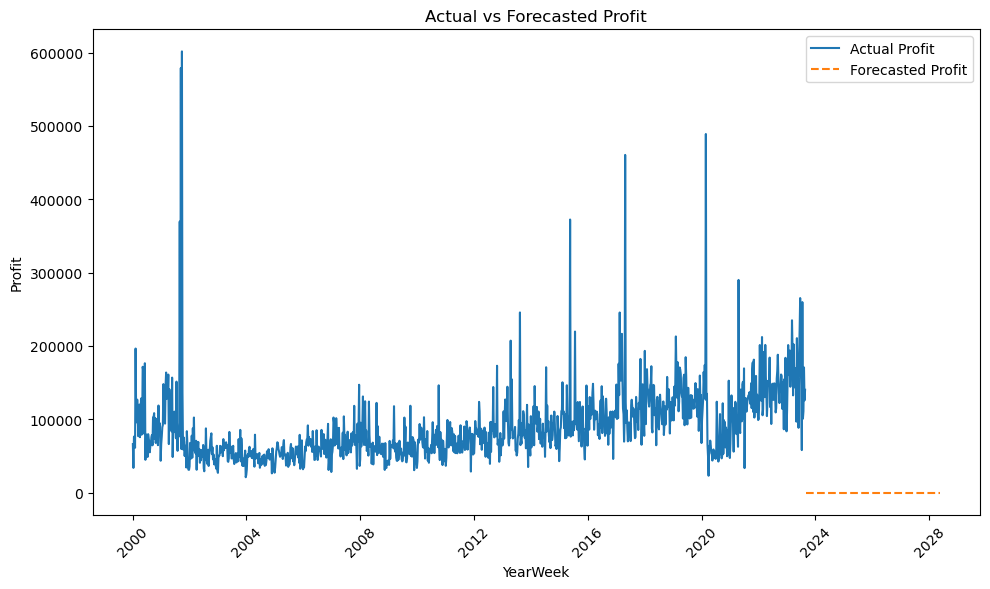

In [20]:
# Ensure 'YearWeek' and 'Profit' are one-dimensional arrays (NumPy)
yearweek_series = profit_grouped_df['YearWeek'].values  # Convert to 1D numpy array
profit_series = profit_grouped_df['Profit'].values      # Convert to 1D numpy array

n_periods = len(test)
# Generate forecast dates for the next 10 periods (weekly frequency) and convert to 1D array
forecast_dates = pd.date_range(yearweek_series[-1], periods=n_periods, freq='W').to_numpy()

# Ensure 'forecast' is a numpy array and 1D
forecast = np.array(forecast_seasonal).flatten()

# Plot actual data
plt.figure(figsize=(10, 6))
plt.plot(yearweek_series, profit_series, label='Actual Profit')

# Plot forecasted data using forecast dates
plt.plot(forecast_dates, forecast, label='Forecasted Profit', linestyle='--')

# Set labels and title
plt.xlabel('YearWeek')
plt.ylabel('Profit')
plt.title('Actual vs Forecasted Profit')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show plot
plt.show()

## Facebook Profet

In [171]:
# !pip install prophet

In [21]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

Text(0.5, 1.0, 'Gross overtime')

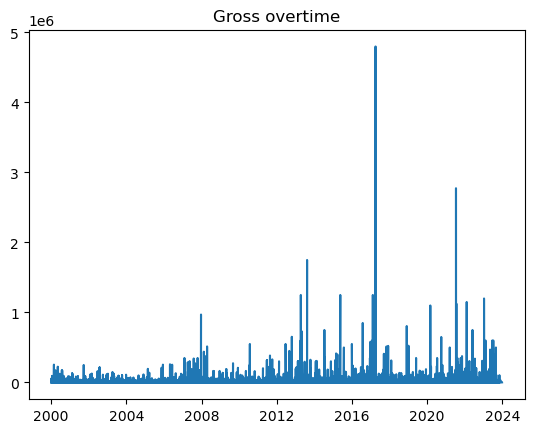

In [22]:
gross_df = Contract_df[['ContractDueDate','Gross','Office','EventType','ActType']]
x=gross_df['ContractDueDate'].to_numpy()
y=gross_df['Gross'].to_numpy()
plt.plot(x,y)
plt.title("Gross overtime")

In [23]:
# Ensure 'ContractDueDate' is in datetime format
gross_df['ContractDueDate'] = pd.to_datetime(gross_df['ContractDueDate'])

/tmp/ipykernel_3514/2563303831.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gross_df['ContractDueDate'] = pd.to_datetime(gross_df['ContractDueDate'])


In [24]:
# One-hot encode the categorical variables
gross_df = pd.get_dummies(gross_df, columns=['Office', 'EventType', 'ActType'])

In [25]:
# Rename 'ContractDueDate' to 'ds' and 'Gross' to 'y'
gross_df.rename(columns={'ContractDueDate': 'ds', 'Gross': 'y'}, inplace=True)

In [26]:
gross_df.columns

Index(['ds', 'y', 'Office_ASH', 'Office_ATL', 'Office_CHS', 'Office_CLT',
       'Office_COL', 'Office_COM', 'Office_FLA', 'Office_HOU', 'Office_NAS',
       'Office_NAT', 'Office_PHL', 'Office_RAL', 'Office_RIC', 'Office_TOR',
       'Office_VAB', 'Office_WDC', 'EventType_Anniversary Party',
       'EventType_Association/Conference/Convention', 'EventType_Banquet',
       'EventType_Bar/Bat Mitzvah', 'EventType_Bar/Nightclub',
       'EventType_Birthday Party', 'EventType_Brunch',
       'EventType_Casino Night', 'EventType_Christmas Party',
       'EventType_Class Reunion', 'EventType_Club', 'EventType_Cocktail Party',
       'EventType_Concert', 'EventType_Convention', 'EventType_Corporate',
       'EventType_Corporate Game Day', 'EventType_Dance',
       'EventType_Debutante Party', 'EventType_Dinner', 'EventType_Fair',
       'EventType_Fairs/Festivals', 'EventType_Festival',
       'EventType_Fraternity Party', 'EventType_Grand Opening',
       'EventType_Happy Hour', 'EventType_

In [27]:
encode_columns = ['Office_ASH', 'Office_ATL', 'Office_CHS', 'Office_CLT',
       'Office_COL', 'Office_COM', 'Office_FLA', 'Office_HOU', 'Office_NAS',
       'Office_NAT', 'Office_PHL', 'Office_RAL', 'Office_RIC', 'Office_TOR',
       'Office_VAB', 'Office_WDC', 'EventType_Anniversary Party',
       'EventType_Association/Conference/Convention', 'EventType_Banquet',
       'EventType_Bar/Bat Mitzvah', 'EventType_Bar/Nightclub',
       'EventType_Birthday Party', 'EventType_Brunch',
       'EventType_Casino Night', 'EventType_Christmas Party',
       'EventType_Class Reunion', 'EventType_Club', 'EventType_Cocktail Party',
       'EventType_Concert', 'EventType_Convention', 'EventType_Corporate',
       'EventType_Corporate Game Day', 'EventType_Dance',
       'EventType_Debutante Party', 'EventType_Dinner', 'EventType_Fair',
       'EventType_Fairs/Festivals', 'EventType_Festival',
       'EventType_Fraternity Party', 'EventType_Grand Opening',
       'EventType_Happy Hour', 'EventType_Hawaiian Luau',
       'EventType_Holiday Party', 'EventType_Homecoming Dance',
       'EventType_Olympic Market', 'EventType_Other',
       'EventType_Outdoor Concert', 'EventType_Party',
       'EventType_Performing Arts', 'EventType_Picnic',
       'EventType_Private/Social', 'EventType_Prom', 'EventType_Reception',
       'EventType_Ring Dance', 'EventType_School/University',
       'EventType_Sorority Party', 'EventType_Surprise Birthday Party',
       'EventType_Unassigned', 'EventType_Wedding',
       'EventType_Wedding Ceremony', 'EventType_Welcome/Rehearsal Party',
       'ActType_Bands', 'ActType_Classical', 'ActType_Comedians',
       'ActType_DJs', 'ActType_International', 'ActType_Nationals',
       'ActType_Performing Arts/Theater', 'ActType_Rock',
       'ActType_Soloist/Duos/Trios', 'ActType_Specialty Musical',
       'ActType_Specialty Non-Musical']

## 3 months

In [132]:
# Resample by every 3 months and calculate the mean for the 'y' (Gross) column
three_month_gross = gross_df.resample('3M', on='ds').mean().reset_index()

# Check the result
print(three_month_gross.head())

          ds            y  Office_ASH  Office_ATL  Office_CHS  Office_CLT  \
0 2000-01-31  3791.556635         0.0    0.285714    0.058201    0.238095   
1 2000-04-30  2711.025310         0.0    0.215783    0.080411    0.320145   
2 2000-07-31  2928.655878         0.0    0.224202    0.076171    0.306985   
3 2000-10-31  2681.488100         0.0    0.199817    0.077299    0.311946   
4 2001-01-31  2679.756904         0.0    0.214181    0.054459    0.314327   

   Office_COL  Office_COM  Office_FLA  Office_HOU  ...  ActType_Classical  \
0    0.026455         0.0         0.0         0.0  ...           0.007407   
1    0.035928         0.0         0.0         0.0  ...           0.005346   
2    0.029606         0.0         0.0         0.0  ...           0.007186   
3    0.032386         0.0         0.0         0.0  ...           0.005805   
4    0.042398         0.0         0.0         0.0  ...           0.005482   

   ActType_Comedians  ActType_DJs  ActType_International  ActType_National

/tmp/ipykernel_30744/3526306761.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  three_month_gross = gross_df.resample('3M', on='ds').mean().reset_index()


In [134]:
# Resample by every 3 months and calculate the mean for the 'y' (Gross) column
three_month_gross = gross_df.resample('3M', on='ds').mean().reset_index()

# Calculate the number of test observations (you can set it manually to 50 periods)
N = 50

# Split the data into training (80%) and test (20%) sets
train_3m_df = three_month_gross[:-N]  # Training data (first 80% of the data)
test_3m_df = three_month_gross[-N:]   # Test data (last 20%)

# Initialize Prophet with 3-month seasonality, yearly seasonality, and US holidays
m_3 = Prophet(weekly_seasonality=False, yearly_seasonality=True, seasonality_prior_scale=10)
m_3.add_seasonality(name='3-month', period=90, fourier_order=5)  # Add 3-month seasonality
m_3.add_country_holidays(country_name='US')  # Add US holidays as a regressor

# Add external regressors (all one-hot encoded columns except 'ds' and 'y')
for column in train_3m_df.columns:
    if column not in ['ds', 'y']:  # Exclude 'ds' (date) and 'y' (target)
        m_3.add_regressor(column)

# Fit the model on the training data
m_3.fit(train_3m_df)


/tmp/ipykernel_30744/4215371663.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  three_month_gross = gross_df.resample('3M', on='ds').mean().reset_index()
02:48:12 - cmdstanpy - INFO - Chain [1] start processing
02:48:26 - cmdstanpy - INFO - Chain [1] done processing


In [135]:
# Step 1: Create a future dataframe for the test set period (next N 3-month periods)
m_3future_fp = m_3.make_future_dataframe(periods=N, freq='3M')  # 3-month frequency

# Include the same external regressors in the future dataframe (if values are known or estimated)
# Here, we will use a simple approach where we fill the future data with static or estimated values
for column in test_3m_df.columns:
    if column not in ['ds', 'y']:  # Exclude 'ds' and 'y'
        # You can fill the future values with either estimates or static values (e.g., the mean)
        m_3future_fp[column] = test_3m_df[column].mean()  # Use a fixed mean value or an estimate for future

# Print future dataframe to verify
print(m_3future_fp.head())

# Step 2: Make predictions for the future period
m_3forecast_fp = m_3.predict(m_3future_fp)

# Step 3: View the forecasted results
print(m_3forecast_fp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

/anaconda/envs/azureml_py38/lib/python3.9/site-packages/prophet/forecaster.py:1803: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


          ds  Office_ASH  Office_ATL  Office_CHS  Office_CLT  Office_COL  \
0 2000-01-31    0.060082    0.158437    0.075372     0.19698    0.036018   
1 2000-04-30    0.060082    0.158437    0.075372     0.19698    0.036018   
2 2000-07-31    0.060082    0.158437    0.075372     0.19698    0.036018   
3 2000-10-31    0.060082    0.158437    0.075372     0.19698    0.036018   
4 2001-01-31    0.060082    0.158437    0.075372     0.19698    0.036018   

   Office_COM  Office_FLA  Office_HOU  Office_NAS  ...  ActType_Classical  \
0    0.011637    0.009405    0.009512    0.017883  ...           0.011122   
1    0.011637    0.009405    0.009512    0.017883  ...           0.011122   
2    0.011637    0.009405    0.009512    0.017883  ...           0.011122   
3    0.011637    0.009405    0.009512    0.017883  ...           0.011122   
4    0.011637    0.009405    0.009512    0.017883  ...           0.011122   

   ActType_Comedians  ActType_DJs  ActType_International  ActType_Nationals  \
0

In [137]:
from sklearn.metrics import r2_score
# Extract the actual values (y) from the 3-month resampled data
m_3_original = three_month_gross[['y']]  # Use the resampled 3-month data for the original values

# Extract the predicted values (yhat) from the 3-month forecasted data
m_3_prediction = m_3forecast_fp[['yhat']]  # Use the forecasted data

# Calculate R-squared score for the predictions
r2 = r2_score(m_3_original[:len(m_3_prediction)], m_3_prediction)  # Ensure length matches between actual and predicted

# Print the R-squared score as a percentage accuracy
print("Accuracy of the model is :", 100 * r2)

Accuracy of the model is : -648813.1537294112


In [138]:
# Extract the true values from the test set (3-month data) and the predicted values from the forecast
m_3_true = test_3m_df['y'].values
m_3_pred = m_3forecast_fp['yhat'].values[-N:]  # Taking only the last N predictions for the test set

# Calculate Mean Absolute Error (MAE)
m_3_mae = mean_absolute_error(m_3_true, m_3_pred)

# Calculate Mean Squared Error (MSE)
m_3_mse = mean_squared_error(m_3_true, m_3_pred)

# Calculate Root Mean Squared Error (RMSE)
m_3_rmse = np.sqrt(m_3_mse)

# Calculate Mean Absolute Percentage Error (MAPE)
m_3_mape = mean_absolute_percentage_error(m_3_true, m_3_pred)

# Print the results
print(f'MAE: {m_3_mae}')
print(f'MSE: {m_3_mse}')
print(f'RMSE: {m_3_rmse}')
print(f'MAPE: {m_3_mape}')

MAE: 201010.64876372876
MSE: 43664215308.89965
RMSE: 208959.84137843244
MAPE: 26.910840763815703


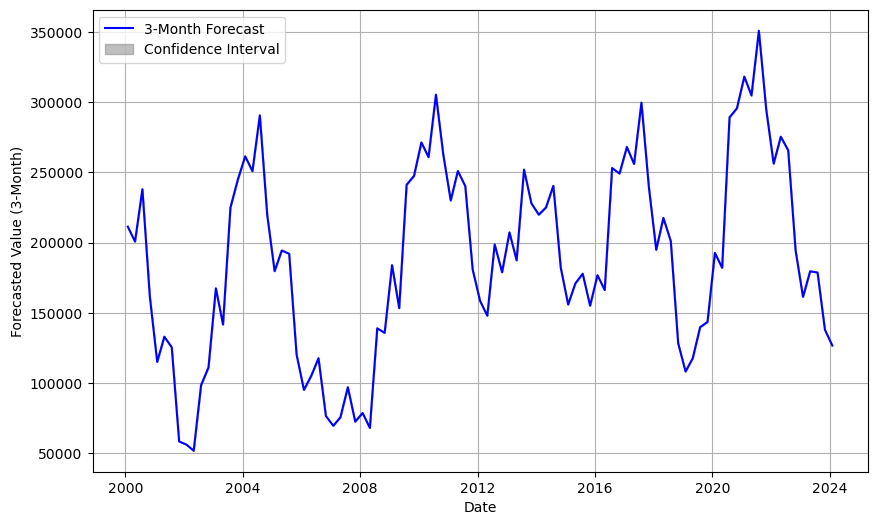

In [139]:
# Convert 'ds', 'yhat', 'yhat_lower', and 'yhat_upper' to numpy arrays for 3-month model
m_3ds_values = np.array(m_3forecast_fp['ds'])
m_3yhat_values = np.array(m_3forecast_fp['yhat'])
m_3yhat_lower_values = np.array(m_3forecast_fp['yhat_lower'])
m_3yhat_upper_values = np.array(m_3forecast_fp['yhat_upper'])

# Plot with numpy arrays for 3-month model
plt.figure(figsize=(10, 6))
plt.plot(m_3ds_values, m_3yhat_values, label='3-Month Forecast', color='blue')
plt.fill_between(m_3ds_values, m_3yhat_lower_values, m_3yhat_upper_values, color='gray', alpha=0.5, label='Confidence Interval')

# Customize and show the plot
plt.xlabel('Date')
plt.ylabel('Forecasted Value (3-Month)')
plt.legend()
plt.grid(True)
plt.show()


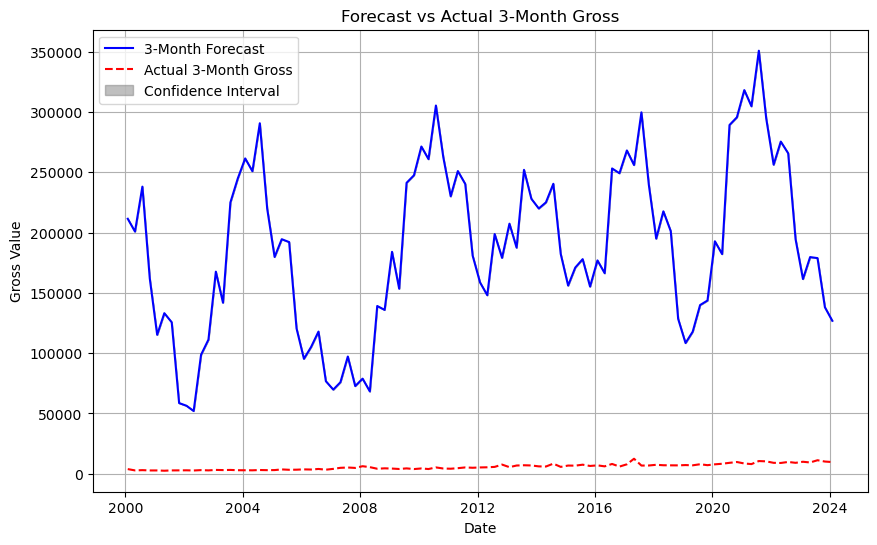

In [140]:
# Convert 'ds', 'yhat', 'yhat_lower', and 'yhat_upper' from the 3-month forecast to numpy arrays
m_3ds_values = np.array(m_3forecast_fp['ds'])
m_3yhat_values = np.array(m_3forecast_fp['yhat'])
m_3yhat_lower_values = np.array(m_3forecast_fp['yhat_lower'])
m_3yhat_upper_values = np.array(m_3forecast_fp['yhat_upper'])

# Convert 'ds' and 'y' from the actual 'three_month_gross' data to numpy arrays
ds_actual_3m = np.array(three_month_gross['ds'])  # Assuming 'three_month_gross' has a 'ds' column
y_actual_3m = np.array(three_month_gross['y'])    # Assuming 'three_month_gross' has a 'y' column for actual values

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(m_3ds_values, m_3yhat_values, label='3-Month Forecast', color='blue')
plt.fill_between(m_3ds_values, m_3yhat_lower_values, m_3yhat_upper_values, color='gray', alpha=0.5, label='Confidence Interval')

# Plot the actual 3-month gross values
plt.plot(ds_actual_3m, y_actual_3m, label='Actual 3-Month Gross', color='red', linestyle='dashed')

# Customize and show the plot
plt.xlabel('Date')
plt.ylabel('Gross Value')
plt.title('Forecast vs Actual 3-Month Gross')
plt.legend()
plt.grid(True)
plt.show()


## Monthly

In [28]:
# Resample by month-end and calculate the mean for the 'y' (Gross) column
monthly_gross = gross_df.resample('ME', on='ds').mean().reset_index()

# Check the result
print(monthly_gross.head())

          ds            y  Office_ASH  Office_ATL  Office_CHS  Office_CLT  \
0 2000-01-31  3791.556635         0.0    0.285714    0.058201    0.238095   
1 2000-02-29  3042.568461         0.0    0.214237    0.079322    0.296271   
2 2000-03-31  2367.371216         0.0    0.215072    0.105061    0.334433   
3 2000-04-30  2809.172090         0.0    0.218366    0.049168    0.326826   
4 2000-05-31  3360.995430         0.0    0.228188    0.066443    0.306711   

   Office_COL  Office_COM  Office_FLA  Office_HOU  ...  ActType_Classical  \
0    0.026455         0.0         0.0         0.0  ...           0.007407   
1    0.037966         0.0         0.0         0.0  ...           0.008136   
2    0.036854         0.0         0.0         0.0  ...           0.004400   
3    0.032538         0.0         0.0         0.0  ...           0.003615   
4    0.019463         0.0         0.0         0.0  ...           0.007383   

   ActType_Comedians  ActType_DJs  ActType_International  ActType_National

In [29]:
# Calculate the number of test observations (20% of total data)
# N = int(len(gross_df) * 0.2)
N = 50

# Split the data into training (80%) and test (20%) sets
mtrain_df = monthly_gross[:-N]  # Training data (first 80% of the data)
mtest_df = monthly_gross[-N:]   # Test data (last 20%)

# Initialize Prophet with monthly seasonality, yearly seasonality, and US holidays
m = Prophet(weekly_seasonality=False, yearly_seasonality=True, seasonality_prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # Add monthly seasonality
m.add_country_holidays(country_name='US')  # Add US holidays as a regressor

# Add external regressors (all one-hot encoded columns except 'ds' and 'y')
for column in mtrain_df.columns:
    if column not in ['ds', 'y']:  # Exclude 'ds' (date) and 'y' (target)
        m.add_regressor(column)

# Fit the model on the training data
m.fit(mtrain_df)

01:39:23 - cmdstanpy - INFO - Chain [1] start processing
01:39:23 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# Step 1: Create a future dataframe for the test set period (next N months)
mfuture_fp = m.make_future_dataframe(periods=N, freq='ME')  # Monthly start frequency

# Include the same external regressors in the future dataframe (if values are known or estimated)
# Here, we will use a simple approach where we fill the future data with static or estimated values
for column in mtest_df.columns:
    if column not in ['ds', 'y']:  # Exclude 'ds' and 'y'
        # You can fill the future values with either estimates or static values (e.g., the mean)
        # Here, we use the mean of the regressor from the test set as a placeholder
        mfuture_fp[column] = mtest_df[column].mean()  # Use a fixed mean value or an estimate for future

# Print future dataframe to verify
print(mfuture_fp.head())

# Step 2: Make predictions for the future period
mforecast_fp = m.predict(mfuture_fp)

# Step 3: View the forecasted results
print(mforecast_fp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

          ds  Office_ASH  Office_ATL  Office_CHS  Office_CLT  Office_COL  \
0 2000-01-31    0.081645    0.117979    0.064927    0.178452    0.035891   
1 2000-02-29    0.081645    0.117979    0.064927    0.178452    0.035891   
2 2000-03-31    0.081645    0.117979    0.064927    0.178452    0.035891   
3 2000-04-30    0.081645    0.117979    0.064927    0.178452    0.035891   
4 2000-05-31    0.081645    0.117979    0.064927    0.178452    0.035891   

   Office_COM  Office_FLA  Office_HOU  Office_NAS  ...  ActType_Classical  \
0     0.02527    0.018449    0.027369    0.048392  ...           0.011286   
1     0.02527    0.018449    0.027369    0.048392  ...           0.011286   
2     0.02527    0.018449    0.027369    0.048392  ...           0.011286   
3     0.02527    0.018449    0.027369    0.048392  ...           0.011286   
4     0.02527    0.018449    0.027369    0.048392  ...           0.011286   

   ActType_Comedians  ActType_DJs  ActType_International  ActType_Nationals  \
0

In [31]:
print(mtest_df['y'].tail())

283    10083.674926
284    10282.510460
285     7350.000000
286    12196.078431
287     1911.764706
Name: y, dtype: float64


In [32]:
from sklearn.metrics import r2_score
m_original=monthly_gross[['y']]
m_prediction=mforecast_fp[['yhat']]
r2_score(m_original,m_prediction)
print("Accuracy of the model is :",100*r2_score(m_original,m_prediction))

Accuracy of the model is : -61.61328416449972


In [33]:
# Extract the true values from the test set and the predicted values from the forecast
my_true = mtest_df['y'].values
my_pred = mforecast_fp['yhat'].values[-N:]  # Taking only the last N predictions for the test set

# Calculate Mean Absolute Error (MAE)
m_mae = mean_absolute_error(my_true, my_pred)

# Calculate Mean Squared Error (MSE)
m_mse = mean_squared_error(my_true, my_pred)

# Calculate Root Mean Squared Error (RMSE)
m_rmse = np.sqrt(m_mse)

# Calculate Mean Absolute Percentage Error (MAPE)
m_mape = mean_absolute_percentage_error(my_true, my_pred)

# Print the results
print(f'MAE: {m_mae}')
print(f'MSE: {m_mse}')
print(f'RMSE: {m_rmse}')
print(f'MAPE: {m_mape}')

MAE: 4074.6144236507216
MSE: 23824780.784282755
RMSE: 4881.063489064934
MAPE: 0.43284686082945156


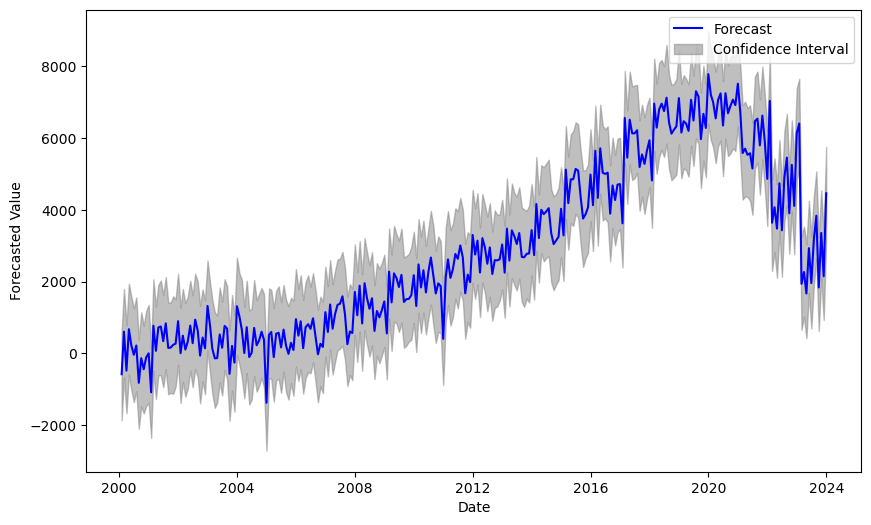

In [34]:
# Convert 'ds', 'yhat', 'yhat_lower', and 'yhat_upper' to numpy arrays
mds_values = np.array(mforecast_fp['ds'])
myhat_values = np.array(mforecast_fp['yhat'])
myhat_lower_values = np.array(mforecast_fp['yhat_lower'])
myhat_upper_values = np.array(mforecast_fp['yhat_upper'])

# Plot with numpy arrays
plt.figure(figsize=(10, 6))
plt.plot(mds_values, myhat_values, label='Forecast', color='blue')
plt.fill_between(mds_values, myhat_lower_values, myhat_upper_values, color='gray', alpha=0.5, label='Confidence Interval')

# Customize and show the plot
plt.xlabel('Date')
plt.ylabel('Forecasted Value')
plt.legend()
plt.show()

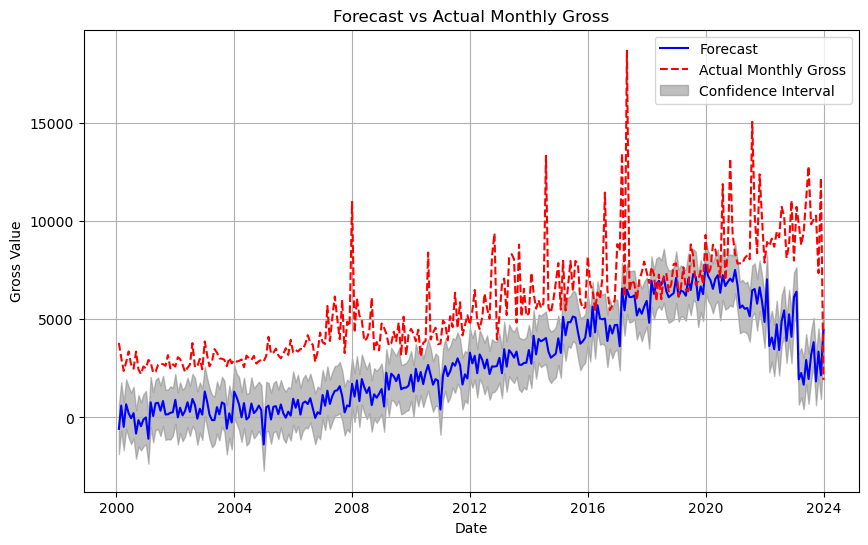

In [35]:

# Convert 'ds', 'yhat', 'yhat_lower', and 'yhat_upper' from forecast to numpy arrays
mds_values = np.array(mforecast_fp['ds'])
myhat_values = np.array(mforecast_fp['yhat'])
myhat_lower_values = np.array(mforecast_fp['yhat_lower'])
myhat_upper_values = np.array(mforecast_fp['yhat_upper'])

# Convert 'ds' and 'y' from the actual 'monthly_gross' data to numpy arrays
ds_actual = np.array(monthly_gross['ds'])  # Assuming 'monthly_gross' has a 'ds' column
y_actual = np.array(monthly_gross['y'])    # Assuming 'monthly_gross' has a 'y' column for actual values

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(mds_values, myhat_values, label='Forecast', color='blue')
plt.fill_between(mds_values, myhat_lower_values, myhat_upper_values, color='gray', alpha=0.5, label='Confidence Interval')

# Plot the actual monthly gross values
plt.plot(ds_actual, y_actual, label='Actual Monthly Gross', color='red', linestyle='dashed')

# Customize and show the plot
plt.xlabel('Date')
plt.ylabel('Gross Value')
plt.title('Forecast vs Actual Monthly Gross')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
import pickle

# Save the model to a file
with open('fb_prophet_monthly_model.pkl', 'wb') as f:
    pickle.dump(m, f)


## Loading the saved model

##### Testing the saved model

In [41]:
# # Load the model from the file
# with open('fb_prophet_monthly_model.pkl', 'rb') as f:
#     m_test = pickle.load(f)


In [42]:
# # Step 1: Create a future dataframe for the test set period (next N months)
# mfuture_fp = m_test.make_future_dataframe(periods=N, freq='ME')  # Monthly start frequency

# # Include the same external regressors in the future dataframe (if values are known or estimated)
# # Here, we will use a simple approach where we fill the future data with static or estimated values
# for column in mtest_df.columns:
#     if column not in ['ds', 'y']:  # Exclude 'ds' and 'y'
#         # You can fill the future values with either estimates or static values (e.g., the mean)
#         # Here, we use the mean of the regressor from the test set as a placeholder
#         mfuture_fp[column] = mtest_df[column].mean()  # Use a fixed mean value or an estimate for future

# # Print future dataframe to verify
# print(mfuture_fp.head())

# # Step 2: Make predictions for the future period
# mforecast_fp = m.predict(mfuture_fp)

# # Step 3: View the forecasted results
# print(mforecast_fp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

In [43]:
# # Extract the true values from the test set and the predicted values from the forecast
# my_true = mtest_df['y'].values
# my_pred = mforecast_fp['yhat'].values[-N:]  # Taking only the last N predictions for the test set

# # Calculate Mean Absolute Error (MAE)
# m_mae = mean_absolute_error(my_true, my_pred)

# # Calculate Mean Squared Error (MSE)
# m_mse = mean_squared_error(my_true, my_pred)

# # Calculate Root Mean Squared Error (RMSE)
# m_rmse = np.sqrt(m_mse)

# # Calculate Mean Absolute Percentage Error (MAPE)
# m_mape = mean_absolute_percentage_error(my_true, my_pred)

# # Print the results
# print(f'MAE: {m_mae}')
# print(f'MSE: {m_mse}')
# print(f'RMSE: {m_rmse}')
# print(f'MAPE: {m_mape}')

In [44]:
# # Convert 'ds', 'yhat', 'yhat_lower', and 'yhat_upper' from forecast to numpy arrays
# mds_values = np.array(mforecast_fp['ds'])
# myhat_values = np.array(mforecast_fp['yhat'])
# myhat_lower_values = np.array(mforecast_fp['yhat_lower'])
# myhat_upper_values = np.array(mforecast_fp['yhat_upper'])

# # Convert 'ds' and 'y' from the actual 'monthly_gross' data to numpy arrays
# ds_actual = np.array(monthly_gross['ds'])  # Assuming 'monthly_gross' has a 'ds' column
# y_actual = np.array(monthly_gross['y'])    # Assuming 'monthly_gross' has a 'y' column for actual values

# # Plot the forecast
# plt.figure(figsize=(10, 6))
# plt.plot(mds_values, myhat_values, label='Forecast', color='blue')
# plt.fill_between(mds_values, myhat_lower_values, myhat_upper_values, color='gray', alpha=0.5, label='Confidence Interval')

# # Plot the actual monthly gross values
# plt.plot(ds_actual, y_actual, label='Actual Monthly Gross', color='red', linestyle='dashed')

# # Customize and show the plot
# plt.xlabel('Date')
# plt.ylabel('Gross Value')
# plt.title('Forecast vs Actual Monthly Gross')
# plt.legend()
# plt.grid(True)
# plt.show()

## Weekly

In [124]:
# Resample by week and calculate the mean for the 'y' (Gross) column
weekly_gross = gross_df.resample('W', on='ds').mean().reset_index()

# Check the result
print(weekly_gross.head())


          ds            y  Office_ASH  Office_ATL  Office_CHS  Office_CLT  \
0 2000-01-02  8811.111111         0.0    0.222222    0.000000    0.000000   
1 2000-01-09  3533.166667         0.0    0.212121    0.045455    0.287879   
2 2000-01-16  2433.665644         0.0    0.276074    0.049080    0.257669   
3 2000-01-23  4649.185164         0.0    0.298182    0.065455    0.240000   
4 2000-01-30  4003.247950         0.0    0.328076    0.047319    0.201893   

   Office_COL  Office_COM  Office_FLA  Office_HOU  ...  ActType_Classical  \
0    0.000000         0.0         0.0         0.0  ...           0.000000   
1    0.007576         0.0         0.0         0.0  ...           0.015152   
2    0.049080         0.0         0.0         0.0  ...           0.000000   
3    0.036364         0.0         0.0         0.0  ...           0.014545   
4    0.009464         0.0         0.0         0.0  ...           0.000000   

   ActType_Comedians  ActType_DJs  ActType_International  ActType_National

In [125]:
# Calculate the number of test observations (you can set it manually to 50 weeks)
N = 50
wtrain_df = weekly_gross[:-N]  
wtest_df = weekly_gross[-N:]   

w = Prophet(weekly_seasonality=True, yearly_seasonality=True, seasonality_prior_scale=10)
w.add_country_holidays(country_name='US')  # Add US holidays as a regressor

for column in wtrain_df.columns:
    if column not in ['ds', 'y']:  # Exclude 'ds' (date) and 'y' (target)
        w.add_regressor(column)

# Fit the model on the training data
w.fit(wtrain_df)

02:40:50 - cmdstanpy - INFO - Chain [1] start processing
02:40:50 - cmdstanpy - INFO - Chain [1] done processing


In [126]:
# Step 1: Create a future dataframe for the test set period (next N months)
wfuture_fp = w.make_future_dataframe(periods=50, freq='W')  # Monthly start frequency

# Include the same external regressors in the future dataframe (if values are known or estimated)
# Here, we will use a simple approach where we fill the future data with static or estimated values
for column in wtest_df.columns:
    if column not in ['ds', 'y']:  # Exclude 'ds' and 'y'
        # You can fill the future values with either estimates or static values (e.g., the mean)
        # Here, we use the mean of the regressor from the test set as a placeholder
        wfuture_fp[column] = wtest_df[column].mean()  # Use a fixed mean value or an estimate for future

# Print future dataframe to verify
print(wfuture_fp.head())

# Step 2: Make predictions for the future period
wforecast_fp = w.predict(wfuture_fp)

# Step 3: View the forecasted results
print(wforecast_fp[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

          ds  Office_ASH  Office_ATL  Office_CHS  Office_CLT  Office_COL  \
0 2000-01-02    0.055873    0.096626    0.055179    0.238905    0.025536   
1 2000-01-09    0.055873    0.096626    0.055179    0.238905    0.025536   
2 2000-01-16    0.055873    0.096626    0.055179    0.238905    0.025536   
3 2000-01-23    0.055873    0.096626    0.055179    0.238905    0.025536   
4 2000-01-30    0.055873    0.096626    0.055179    0.238905    0.025536   

   Office_COM  Office_FLA  Office_HOU  Office_NAS  ...  ActType_Classical  \
0    0.022976    0.011985         0.0    0.153424  ...           0.015339   
1    0.022976    0.011985         0.0    0.153424  ...           0.015339   
2    0.022976    0.011985         0.0    0.153424  ...           0.015339   
3    0.022976    0.011985         0.0    0.153424  ...           0.015339   
4    0.022976    0.011985         0.0    0.153424  ...           0.015339   

   ActType_Comedians  ActType_DJs  ActType_International  ActType_Nationals  \
0

In [128]:
from sklearn.metrics import r2_score
w_original=weekly_gross[['y']]
w_prediction=wforecast_fp[['yhat']]
r2_score(w_original,w_prediction)
print("Accuracy of the model is :",100*r2_score(w_original,w_prediction))

ValueError: Input contains NaN.

In [129]:
# Extract the true values from the test set and the predicted values from the forecast
wy_true = wtest_df['y'].values
wy_pred = wforecast_fp['yhat'].values[-N:]  # Taking only the last N predictions for the test set

# Calculate Mean Absolute Error (MAE)
w_mae = mean_absolute_error(wy_true, wy_pred)

# Calculate Mean Squared Error (MSE)
w_mse = mean_squared_error(wy_true, wy_pred)

# Calculate Root Mean Squared Error (RMSE)
w_rmse = np.sqrt(w_mse)

# Calculate Mean Absolute Percentage Error (MAPE)
w_mape = mean_absolute_percentage_error(wy_true, wy_pred)

# Print the results
print(f'MAE: {w_mae}')
print(f'MSE: {w_mse}')
print(f'RMSE: {w_rmse}')
print(f'MAPE: {w_mape}')

ValueError: Input contains NaN.

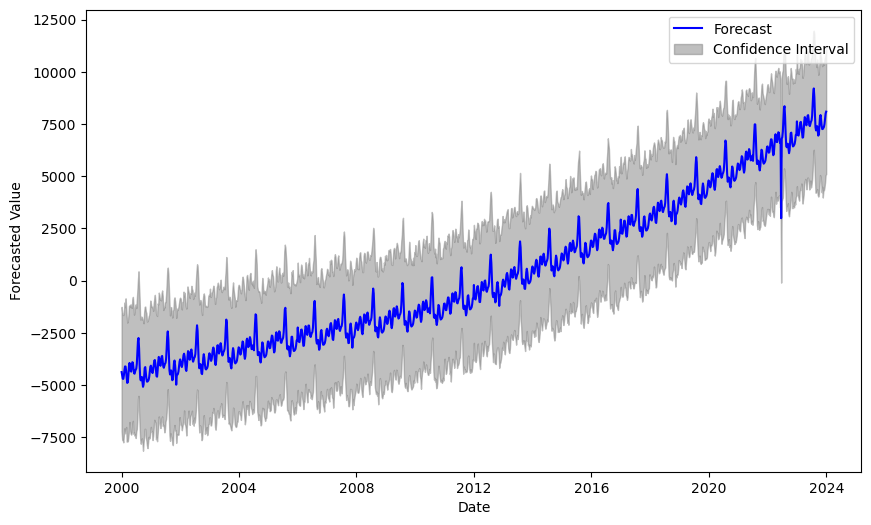

In [130]:
# Convert 'ds', 'yhat', 'yhat_lower', and 'yhat_upper' to numpy arrays
wds_values = np.array(wforecast_fp['ds'])
wyhat_values = np.array(wforecast_fp['yhat'])
wyhat_lower_values = np.array(wforecast_fp['yhat_lower'])
wyhat_upper_values = np.array(wforecast_fp['yhat_upper'])

# Plot with numpy arrays
plt.figure(figsize=(10, 6))
plt.plot(wds_values, wyhat_values, label='Forecast', color='blue')
plt.fill_between(wds_values, wyhat_lower_values, wyhat_upper_values, color='gray', alpha=0.5, label='Confidence Interval')

# Customize and show the plot
plt.xlabel('Date')
plt.ylabel('Forecasted Value')
plt.legend()
plt.show()

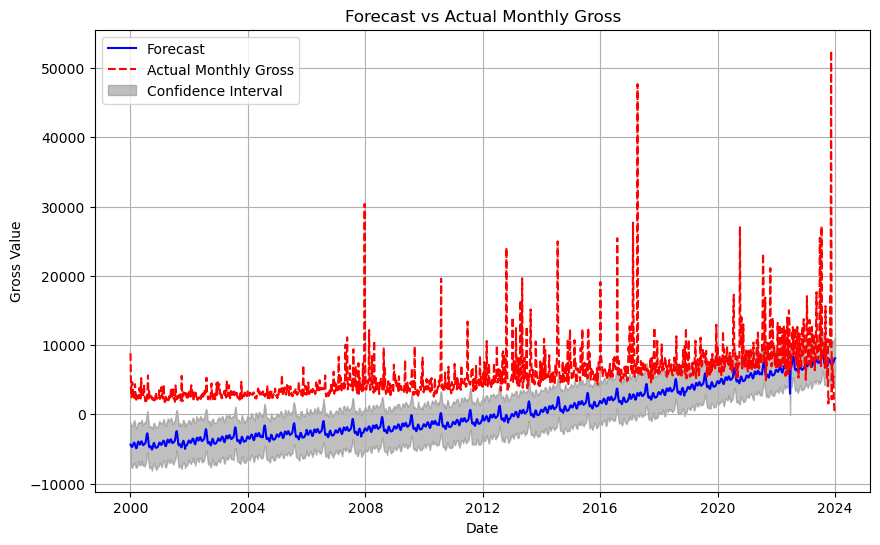

In [131]:
# Convert 'ds', 'yhat', 'yhat_lower', and 'yhat_upper' from forecast to numpy arrays
wds_values = np.array(wforecast_fp['ds'])
wyhat_values = np.array(wforecast_fp['yhat'])
wyhat_lower_values = np.array(wforecast_fp['yhat_lower'])
wyhat_upper_values = np.array(wforecast_fp['yhat_upper'])

# Convert 'ds' and 'y' from the actual 'monthly_gross' data to numpy arrays
ds_actual = np.array(weekly_gross['ds'])  # Assuming 'monthly_gross' has a 'ds' column
y_actual = np.array(weekly_gross['y'])    # Assuming 'monthly_gross' has a 'y' column for actual values

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(wds_values, wyhat_values, label='Forecast', color='blue')
plt.fill_between(wds_values, wyhat_lower_values, wyhat_upper_values, color='gray', alpha=0.5, label='Confidence Interval')

# Plot the actual monthly gross values
plt.plot(ds_actual, y_actual, label='Actual Monthly Gross', color='red', linestyle='dashed')

# Customize and show the plot
plt.xlabel('Date')
plt.ylabel('Gross Value')
plt.title('Forecast vs Actual Monthly Gross')
plt.legend()
plt.grid(True)
plt.show()

## LSTM

In [143]:
!pip install tensorflow


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 82.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 76.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 73.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4832 sha256=6665515ec14ef37fb13031a7f8ac87ca10f09b325b0e816c0030901c44c6ec03
  Stored in directory: /home/azureuser/.cache/pip/wheels/6d/00/51/e04e70a050b271a6aac779726204a324ada2b39b99334175c3
  Created wheel for wrapt: filename=wrapt-1.12.1-cp39-cp39-linux_x86_64.whl size=36931 sha256=64a50ff6f5aa70051d4b8e0498f61d280d5537a9b262535cf221cc4e10269301
  Stored in directory: /home/azureuser/.cache/pip/wheels/17/9a/15/aa98fc9b0b6ffab6b5da684f221955a48ce18831058ca2376b
Successfully built termcolor

In [148]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 63.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 73.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 78.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 91.7 MB/s eta 0:00:00:00:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
  Attempting uni

In [149]:
# Assuming 'monthly_gross' is your DataFrame with 'ds' (date) and 'y' (gross value)
data = monthly_gross[['y']].values

# Scale the data to the range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Convert the data into sequences (X, y)
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])  # Use the last 'seq_length' values as input
        y.append(data[i, 0])  # The next value in the sequence is the target
    return np.array(X), np.array(y)

# Define the sequence length (e.g., 12 months for a yearly window)
sequence_length = 12
X, y = create_sequences(scaled_data, sequence_length)

# Reshape X to be 3D for LSTM: (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [150]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [151]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [152]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [154]:
# Build the LSTM model
model = Sequential()

# Add LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Add another LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/anaconda/envs/azureml_py38/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_30744/2799990697.py", line 5, in <module>
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  File "/anaconda/envs/azureml_py38/lib/python3.9/site-packages/tensorflow/python/training/tracking/base.py", line 522, in _method_wrapper
  File "/anaconda/envs/azureml_py38/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py", line 213, in add
    if set_inputs:
  File "/anaconda/envs/azureml_py38/lib/python3.9/site-packages/tensorflow/python/keras/layers/recurrent.py", line 668, in __call__
    # If any of `initial_state` or `constants` are specified and are Keras
  File "/anaconda/envs/azureml_py38/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py", line 969, in __call__
    # - in